In [1]:
# import the necessary packages
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
import torch
import torchvision
import torchvision.transforms as transforms
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)


In [2]:
#loading the data as traindata and test data 
#The compose function allows for multiple transforms
#transforms.ToTensor() converts our PILImage to a tensor of shape (C x H x W) in the range [0,1]
#transforms.Normalize(mean,std) normalizes a tensor to a (mean, std) for (R, G, B)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_set = torchvision.datasets.ImageFolder('C:/Users/Mayank/Downloads/trainimages',transform=transform)
trainloader = torch.utils.data.DataLoader(train_set, batch_size=4,shuffle=True, num_workers=2)
test_set = torchvision.datasets.ImageFolder('C:/Users/Mayank/Downloads/testimagess',transform=transform)
testloader = torch.utils.data.DataLoader(test_set, batch_size=4,shuffle=True, num_workers=2)

In [3]:
#different classes for classification
classes=('CEREAL','CHOCOLATE','COFFEE','HONEY','JAM','JUICE','NUTS','SPICES','TEA','TOMATO_SAUCE')

In [4]:
from torch.utils.data.sampler import SubsetRandomSampler

#Training
n_training_samples = 2000
train_sampler = SubsetRandomSampler(np.arange(n_training_samples, dtype=np.int64))

#Validation
n_val_samples = 100
val_sampler = SubsetRandomSampler(np.arange(n_training_samples, n_training_samples + n_val_samples, dtype=np.int64))

#Test
n_test_samples = 800
test_sampler = SubsetRandomSampler(np.arange(n_test_samples, dtype=np.int64))

In [5]:
import torch.nn as nn
#import torch.nn.functional as F
#from torch.autograd import Variable
from torch.autograd import Variable
import torch.nn.functional as F

# define the CNN architecture
class SimpleCNN(torch.nn.Module): #earlier nn.
    
    def __init__(self):
        super(SimpleCNN, self).__init__()
    
        #Input Channel = 3, Ouput Channel = 8, Image Dim = 3*256*256 
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, padding=1) # convolutional layer 1
        
        #Image Dim=8*128*128
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3,padding=1) # convolutional layer 2
        
        #Image Dim=16*64*64
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, padding=1) # convolutional layer 3
       
        #Image Dim=32*32*32
        self.conv4 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # convolutional layer 4
         
        #Image Dim=64*16*16
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3,padding=1) # convolutional layer 5
        #Image Dim=128*8*8
        
        self.pool = nn.MaxPool2d(2,2,0) # max pooling layer
        #self.drop2d = nn.Dropout2d(0.2)
        
        
        #Image Dim=128*8*8, 8192 input features, 64 output features 
        self.fc1 = nn.Linear(128*8*8, 64) # fully connected layer 1
        
        #64 input features classifying into 10 classes(output)
        self.fc2 = nn.Linear(64, 10) #fully connected layer 2
        self.dropout = nn.Dropout(0.2) 
    
    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        x = x.view(-1, 128*8*8)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x 

In [6]:
def outputSize(in_size, kernel_size, stride, padding):

    output = int((in_size - kernel_size + 2*(padding)) / stride) + 1

    return(output)

In [7]:
#DataLoader takes in a dataset and a sampler for loading (num_workers deals with system level memory) 
def get_train_loader(batch_size):
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                           sampler=train_sampler, num_workers=2)
    return(train_loader)

In [8]:
#Test loader have constant batch sizes, so we can define them directly
test_loader = torch.utils.data.DataLoader(test_set, batch_size=4, sampler=test_sampler, num_workers=2)
val_loader = torch.utils.data.DataLoader(train_set, batch_size=128, sampler=val_sampler, num_workers=2)

In [9]:
#loss and optimizer function
import torch.optim as optim

def createLossAndOptimizer(net, learning_rate=0.001):
    
    #Loss function
    loss = torch.nn.CrossEntropyLoss()
    
    #Optimizer
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    
    return(loss, optimizer)

In [10]:
import time

def trainNet(net, batch_size, n_epochs, learning_rate):
    
    #Print all of the hyperparameters of the training iteration:
    print("===== HYPERPARAMETERS =====")
    print("batch_size=", batch_size)
    print("epochs=", n_epochs)
    print("learning_rate=", learning_rate)
    print("=" * 30)
    
    #Get training data
    train_loader = get_train_loader(batch_size)
    n_batches = len(train_loader)
    
    #Create our loss and optimizer functions
    loss, optimizer = createLossAndOptimizer(net, learning_rate)
    
    #Time for printing
    training_start_time = time.time()
    
    #Loop for n_epochs
    for epoch in range(n_epochs):
        
        running_loss = 0.0
        print_every = n_batches // 10
        start_time = time.time()
        total_train_loss = 0
        
        for i, data in enumerate(train_loader, 0):
            
            #Get inputs
            inputs, labels = data
            
            #Wrap them in a Variable object
            inputs, labels = Variable(inputs), Variable(labels)
            
            #Set the parameter gradients to zero
            optimizer.zero_grad()
            
            #Forward pass, backward pass, optimize
            outputs = net(inputs)
            loss_size = loss(outputs, labels)
            loss_size.backward()
            optimizer.step()
            
            #Print statistics
            running_loss += loss_size.data[0]
            total_train_loss += loss_size.data[0]
            
            #Print every 10th batch of an epoch
            if (i + 1) % (print_every + 1) == 0:
                print("Epoch {}, {:d}% \t train_loss: {:.2f} took: {:.2f}s".format(
                        epoch+1, int(100 * (i+1) / n_batches), running_loss / print_every, time.time() - start_time))
                #Reset running loss and time
                running_loss = 0.0
                start_time = time.time()
            
        #At the end of the epoch, do a pass on the validation set
        total_val_loss = 0
        for inputs, labels in val_loader:
            
            #Wrap tensors in Variables
            inputs, labels = Variable(inputs), Variable(labels)
            
            #Forward pass
            val_outputs = net(inputs)
            val_loss_size = loss(val_outputs, labels)
            total_val_loss += val_loss_size.data[0]
            
        print("Validation loss = {:.2f}".format(total_val_loss / len(val_loader)))
        
    print("Training finished, took {:.2f}s".format(time.time() - training_start_time))

In [11]:
CNN = SimpleCNN()
trainNet(CNN, batch_size=32, n_epochs=50, learning_rate=0.001)

===== HYPERPARAMETERS =====
batch_size= 32
epochs= 50
learning_rate= 0.001


C:\Users\Mayank\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
C:\Users\Mayank\Anaconda3\lib\site-packages\ipykernel_launcher.py:49: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 1, 11% 	 train_loss: 2.65 took: 30.23s
Epoch 1, 22% 	 train_loss: 2.59 took: 19.36s
Epoch 1, 33% 	 train_loss: 2.57 took: 18.10s
Epoch 1, 44% 	 train_loss: 2.57 took: 18.58s
Epoch 1, 55% 	 train_loss: 2.52 took: 18.33s
Epoch 1, 66% 	 train_loss: 2.42 took: 20.10s
Epoch 1, 77% 	 train_loss: 2.36 took: 18.94s
Epoch 1, 88% 	 train_loss: 2.31 took: 18.47s
Epoch 1, 100% 	 train_loss: 2.32 took: 16.69s


C:\Users\Mayank\Anaconda3\lib\site-packages\ipykernel_launcher.py:69: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation loss = 3.31
Epoch 2, 11% 	 train_loss: 2.31 took: 56.80s
Epoch 2, 22% 	 train_loss: 2.35 took: 16.28s
Epoch 2, 33% 	 train_loss: 2.24 took: 19.70s
Epoch 2, 44% 	 train_loss: 2.37 took: 18.98s
Epoch 2, 55% 	 train_loss: 2.25 took: 18.07s
Epoch 2, 66% 	 train_loss: 2.28 took: 18.62s
Epoch 2, 77% 	 train_loss: 2.27 took: 19.33s
Epoch 2, 88% 	 train_loss: 2.25 took: 19.74s
Epoch 2, 100% 	 train_loss: 2.18 took: 16.48s
Validation loss = 3.77
Epoch 3, 11% 	 train_loss: 2.13 took: 31.74s
Epoch 3, 22% 	 train_loss: 2.09 took: 23.53s
Epoch 3, 33% 	 train_loss: 2.12 took: 19.95s
Epoch 3, 44% 	 train_loss: 2.12 took: 17.94s
Epoch 3, 55% 	 train_loss: 2.22 took: 18.83s
Epoch 3, 66% 	 train_loss: 2.13 took: 19.46s
Epoch 3, 77% 	 train_loss: 2.12 took: 18.18s
Epoch 3, 88% 	 train_loss: 2.09 took: 18.35s
Epoch 3, 100% 	 train_loss: 2.10 took: 19.25s
Validation loss = 3.60
Epoch 4, 11% 	 train_loss: 2.01 took: 74.55s
Epoch 4, 22% 	 train_loss: 2.01 took: 21.53s
Epoch 4, 33% 	 train_loss: 2.

Epoch 20, 100% 	 train_loss: 0.60 took: 13.22s
Validation loss = 10.03
Epoch 21, 11% 	 train_loss: 0.56 took: 18.33s
Epoch 21, 22% 	 train_loss: 0.50 took: 15.62s
Epoch 21, 33% 	 train_loss: 0.48 took: 15.59s
Epoch 21, 44% 	 train_loss: 0.54 took: 15.15s
Epoch 21, 55% 	 train_loss: 0.51 took: 15.22s
Epoch 21, 66% 	 train_loss: 0.59 took: 15.32s
Epoch 21, 77% 	 train_loss: 0.62 took: 15.20s
Epoch 21, 88% 	 train_loss: 0.65 took: 14.69s
Epoch 21, 100% 	 train_loss: 0.54 took: 13.28s
Validation loss = 11.03
Epoch 22, 11% 	 train_loss: 0.53 took: 18.34s
Epoch 22, 22% 	 train_loss: 0.42 took: 15.47s
Epoch 22, 33% 	 train_loss: 0.45 took: 15.85s
Epoch 22, 44% 	 train_loss: 0.52 took: 15.41s
Epoch 22, 55% 	 train_loss: 0.55 took: 14.97s
Epoch 22, 66% 	 train_loss: 0.56 took: 15.11s
Epoch 22, 77% 	 train_loss: 0.43 took: 15.46s
Epoch 22, 88% 	 train_loss: 0.56 took: 14.76s
Epoch 22, 100% 	 train_loss: 0.52 took: 13.55s
Validation loss = 12.39
Epoch 23, 11% 	 train_loss: 0.47 took: 18.51s
Epoch

Epoch 39, 66% 	 train_loss: 0.36 took: 16.99s
Epoch 39, 77% 	 train_loss: 0.30 took: 17.63s
Epoch 39, 88% 	 train_loss: 0.22 took: 17.12s
Epoch 39, 100% 	 train_loss: 0.24 took: 19.86s
Validation loss = 14.57
Epoch 40, 11% 	 train_loss: 0.28 took: 59.95s
Epoch 40, 22% 	 train_loss: 0.27 took: 16.54s
Epoch 40, 33% 	 train_loss: 0.28 took: 20.69s
Epoch 40, 44% 	 train_loss: 0.21 took: 16.94s
Epoch 40, 55% 	 train_loss: 0.21 took: 18.28s
Epoch 40, 66% 	 train_loss: 0.26 took: 17.72s
Epoch 40, 77% 	 train_loss: 0.25 took: 17.33s
Epoch 40, 88% 	 train_loss: 0.22 took: 17.46s
Epoch 40, 100% 	 train_loss: 0.24 took: 15.84s
Validation loss = 17.98
Epoch 41, 11% 	 train_loss: 0.24 took: 63.55s
Epoch 41, 22% 	 train_loss: 0.31 took: 17.47s
Epoch 41, 33% 	 train_loss: 0.23 took: 17.26s
Epoch 41, 44% 	 train_loss: 0.17 took: 17.36s
Epoch 41, 55% 	 train_loss: 0.28 took: 17.38s
Epoch 41, 66% 	 train_loss: 0.22 took: 17.51s
Epoch 41, 77% 	 train_loss: 0.21 took: 18.56s
Epoch 41, 88% 	 train_loss: 0.

JUICE JUICE COFFEE SPICES


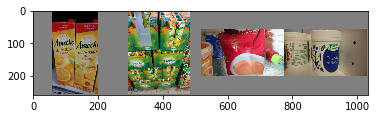

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
#print(labels)
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))



In [21]:
outputss=CNN(images)

In [22]:
_, predicted = torch.max(outputss, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:  JUICE JUICE COFFEE SPICES


In [23]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = CNN(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 400 test images: %d %%' % (
    100 * correct / total))

#conf_matrix = metrics.confusion_matrix(predicted, dataiter)

Accuracy of the network on the 400 test images: 55 %


In [24]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs =CNN(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(1):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of CEREAL : 42 %
Accuracy of CHOCOLATE : 100 %
Accuracy of COFFEE : 40 %
Accuracy of HONEY : 50 %
Accuracy of   JAM : 100 %
Accuracy of JUICE : 92 %
Accuracy of  NUTS : 100 %
Accuracy of SPICES :  8 %
Accuracy of   TEA : 22 %
Accuracy of TOMATO_SAUCE :  0 %


C:\Users\Mayank\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  # This is added back by InteractiveShellApp.init_path()


In [18]:
images.shape

torch.Size([1, 3, 256, 256])